# Imports

In [1]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data parsing

In [2]:
import os
import shutil
import subprocess

def download_and_extract_librispeech(destination_folder="/kaggle/working"):
    """
    Downloads and extracts the LibriSpeech dev-clean dataset.
    Moves all audio files into a dedicated clean speech folder.
    """
    librispeech_url = "http://openslr.elda.org/resources/12/dev-clean.tar.gz"
    librispeech_tar = os.path.join(destination_folder, "dev-clean.tar.gz")
    clean_speech_folder = os.path.join(destination_folder, "clean_speech")

    # Download dataset & extract files
    subprocess.run(["wget", librispeech_url, "-O", librispeech_tar])
    subprocess.run(["tar", "-xvf", librispeech_tar, "-C", destination_folder])
    
    os.makedirs(clean_speech_folder, exist_ok=True)

    # Move all .flac files to clean_speech
    for root, _, files in os.walk(os.path.join(destination_folder, "LibriSpeech/dev-clean")):
        for file in files:
            if file.endswith(".flac"):
                src = os.path.join(root, file)
                dest = os.path.join(clean_speech_folder, file)
                shutil.copy2(src, dest)

    # Clean up original dataset folder
    shutil.rmtree(os.path.join(destination_folder, "LibriSpeech"))

    print(f"Clean speech files saved to {clean_speech_folder}")


def download_and_extract_esc50(destination_folder="/kaggle/working"):
    """
    Downloads and extracts the ESC-50 dataset.
    Moves all noise audio files into a dedicated noise folder.
    """
    esc50_url = "https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master"
    esc50_zip = os.path.join(destination_folder, "ESC-50-master.zip")
    noise_folder = os.path.join(destination_folder, "noise")

    # Download dataset &dExtract files
    subprocess.run(["wget", esc50_url, "-O", esc50_zip])
    subprocess.run(["unzip", esc50_zip, "-d", destination_folder])

    # Create noise folder
    os.makedirs(noise_folder, exist_ok=True)

    # Move all .wav files to noise folder
    for root, _, files in os.walk(os.path.join(destination_folder, "ESC-50-master/audio")):
        for file in files:
            if file.endswith(".wav"):
                src = os.path.join(root, file)
                dest = os.path.join(noise_folder, file)
                shutil.copy2(src, dest)

    # Clean up original dataset folder
    shutil.rmtree(os.path.join(destination_folder, "ESC-50-master"))

    print(f"Noise files saved to {noise_folder}")

In [3]:
download_and_extract_librispeech()
download_and_extract_esc50()

Clean speech files saved to /kaggle/working/clean_speech
Noise files saved to /kaggle/working/noise


In [4]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=8000

for i in os.listdir('/kaggle/working/clean_speech'):
  count_clean += 1
  y,sr = librosa.load(os.path.join('/kaggle/working/clean_speech',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_clean+=duration

print(f'Number of clean audio files are {count_clean}')
print(f'Total duration of all clean audios {duration_clean//60}')

count_noise = 0
for i in os.listdir('/kaggle/working/noise'):
  count_noise += 1
  y,sr = librosa.load(os.path.join('/kaggle/working/noise',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_noise+=duration

print(f'Number of Noisy audio files are {count_noise}')
print(f'Total duration of all noise audios {duration_noise//60}')

Number of clean audio files are 2703
Total duration of all clean audios 323.0
Number of Noisy audio files are 2000
Total duration of all noise audios 166.0


In [5]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]
    # Creating several audio frames using sliding windows
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    # Combining all the frames to single matrix
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [6]:
# Required variables for Audio
noise_dir="/kaggle/working/noise/"
voice_dir="/kaggle/working/clean_speech/"
path_save_spectrogram="/kaggle/working/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1

In [7]:
# clean Audio files
clean_audio_files = os.listdir(voice_dir)
# Selecting a random audio from clean speech
clean_random_audio = np.random.choice(clean_audio_files)
# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)
# Converting to Audio to numpy matrix
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

Clean Audio: 777-126732-0033.flac
Shape:(3, 8064)


In [8]:
# Noisy Audio files
noisy_audio_files = os.listdir(voice_dir)
# Selecting a random audio from noise data
noisy_random_audio = np.random.choice(clean_audio_files)
# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,noisy_random_audio),sr=sample_rate)
# Converting the Audio to numpy matrix
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))

Noise Audio: 3576-138058-0023.flac
Shape:(10, 8064)


In [9]:
clean = np.vstack(clean)
noise = np.vstack(noise)

In [10]:
print(clean)
print(noise)

[[ 7.1615400e-04  7.0610677e-04  3.7198392e-04 ...  4.8575515e-04
   8.7964011e-04  5.1834481e-04]
 [ 3.3727800e-04 -6.6695735e-05  9.0507464e-04 ... -2.4704710e-03
  -2.0118151e-04  4.2328243e-03]
 [ 3.2340209e-03 -5.0155446e-04 -4.8505533e-03 ... -8.7505504e-03
  -9.8416777e-03 -1.1773480e-02]]
[[ 0.00109445  0.00182787  0.00244739 ...  0.00519904  0.00364658
   0.00100436]
 [-0.00267121 -0.0047173  -0.00893596 ... -0.00282892 -0.00291963
   0.00523734]
 [ 0.00301072  0.00687935  0.01684547 ...  0.00479798  0.00180053
  -0.00166314]
 ...
 [-0.05573978 -0.06625199 -0.05624792 ...  0.08632219  0.0887325
   0.08221426]
 [ 0.0810225   0.08503382  0.07670803 ... -0.01730586 -0.01257438
  -0.00733197]
 [-0.00231648  0.00445764  0.0101822  ...  0.06288802  0.05029171
   0.02310342]]


In [11]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [12]:
prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(voice=clean,noise=noise,nb_samples=10,frame_length=frame_length)

In [13]:
prod_voice.shape

(10, 8064)

In [14]:
samples_clean = []
samples_noisy_clean = []
for x in prod_voice:
  samples_clean.extend(x)

for x in prod_noisy_voice:
  samples_noisy_clean.extend(x)

In [15]:
print(len(samples_clean))
print(len(samples_noisy_clean))

80640
80640


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()

In [ ]:
# Saving and playing clean voice
import soundfile as sf
clean_nb_samples = prod_voice.shape[0]
#Save all frames in one file
clean_long = prod_voice.reshape(1, 10 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("clean_long.wav", clean_long[0,:], 8000, 'PCM_24')

In [ ]:
from IPython.display import Audio
Audio('clean_long.wav')

In [ ]:
# Saving and playing noisy voice
noise_nb_samples = prod_noisy_voice.shape[0]
#Save all frames in one file
noise_long = prod_noisy_voice.reshape(1, 10 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("noise_long.wav", noise_long[0,:], 8000, 'PCM_24')

In [ ]:
from IPython.display import Audio
Audio('noise_long.wav')

# Simple model for de-noising.

In [ ]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

In [ ]:
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [ ]:
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    count = 0
    for file in list_audio_files:
    # open the audio file
      try:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        # Getting duration of audio file
        total_duration = librosa.get_duration(y=y, sr=sr)
      except ZeroDivisionError:
        count += 1

        # Check if the duration is atleast the minimum duration
      if (total_duration >= min_duration):
          list_sound_array.append(audio_to_audio_frame_stack(
              y, frame_length, hop_length_frame))
      else:
          print(
              f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)

In [ ]:
#Data Prepare
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
    and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
    time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
    parameters defined in args module"""

    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)


    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)             #Not required
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

In [25]:
# Creating folder save the audio spectograms
!mkdir spectogram


noise_dir="/kaggle/working/noise/"
voice_dir="/kaggle/working/clean_speech/"
path_save_spectrogram="/kaggle/working/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=2000
n_fft=255
hop_length_fft=63

create_data(noise_dir=noise_dir,voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,
            min_duration=min_duration,
            frame_length=frame_length,
            hop_length_frame=hop_length_frame,
            hop_length_frame_noise=hop_length_frame_noise,
            nb_samples=nb_samples,
            n_fft=n_fft,
            hop_length_fft=hop_length_fft)

noisy_voice_amp_db = np.load('/kaggle/working/spectogram/noisy_voice_amp_db.npy')
print(np.shape(noisy_voice_amp_db))


(2000, 128, 128)


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Audio

# Define helper functions for audio processing

def load_spectrograms(path_save_spectrogram):
    noisy_spectrogram = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
    clean_spectrogram = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))
    return noisy_spectrogram, clean_spectrogram

def spectrogram_to_waveform(spectrogram, n_fft, hop_length_fft):
    # Convert dB-scaled spectrogram back to amplitude
    amplitude = librosa.db_to_amplitude(spectrogram)
    # Pad amplitude to ensure the correct size for iSTFT
    if amplitude.shape[0] < n_fft:
        amplitude = np.pad(amplitude, ((0, n_fft - amplitude.shape[0]), (0, 0)), mode='constant')
    # Convert amplitude spectrogram to waveform
    waveform = librosa.istft(amplitude, hop_length=hop_length_fft, win_length=n_fft)
    return waveform

def plot_waveforms(samples_clean, samples_noisy, samples_denoised, sr=8000):
    plt.figure(figsize=(30, 10))

    plt.subplot(311)
    plt.title("Clean Speech")
    plt.plot(samples_clean)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.title("Noisy Speech")
    plt.plot(samples_noisy)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(313)
    plt.title("Denoised Speech")
    plt.plot(samples_denoised)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Define paths and parameters
path_save_spectrogram = "/kaggle/working/spectogram/"
n_fft = 255
hop_length_fft = 63
sample_rate = 8000

# Load spectrograms
noisy_spectrogram, clean_spectrogram = load_spectrograms(path_save_spectrogram)

# Assume the model is already trained and you have the denoised spectrograms
# For demonstration, let's assume denoised_spectrogram is the same as clean_spectrogram
denoised_spectrogram = clean_spectrogram  # Replace this with the actual denoised output from your model

# Convert spectrograms to waveforms
noisy_waveform = spectrogram_to_waveform(noisy_spectrogram[0], n_fft, hop_length_fft)
clean_waveform = spectrogram_to_waveform(clean_spectrogram[0], n_fft, hop_length_fft)
denoised_waveform = spectrogram_to_waveform(denoised_spectrogram[0], n_fft, hop_length_fft)

# Save waveforms as audio files
sf.write("noisy.wav", noisy_waveform, sample_rate)
sf.write("clean.wav", clean_waveform, sample_rate)
sf.write("denoised.wav", denoised_waveform, sample_rate)

# Plot waveforms
plot_waveforms(clean_waveform, noisy_waveform, denoised_waveform, sr=sample_rate)

# Play audio files
display(Audio("noisy.wav"))
display(Audio("clean.wav"))
display(Audio("denoised.wav"))


In [27]:
noisy_voice = np.load("/kaggle/working/spectogram/noisy_voice_amp_db.npy")
voice = np.load("/kaggle/working/spectogram/voice_amp_db.npy")
noise = noisy_voice-voice

In [28]:
print(noisy_voice.shape)
print(noise.shape)

(2000, 128, 128)
(2000, 128, 128)


In [29]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec
from scipy import stats


X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
#Model of noise to predict
X_ou = X_in - X_ou

#Check distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

#to scale between -1 and 1
X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

#Check shape of spectrograms
print(X_in.shape)
print(X_ou.shape)
#Check new distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))


#Reshape for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)
# print(X_in.shape)
# print(X_out.shape)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

DescribeResult(nobs=32768000, minmax=(array([-80.]), array([7.10542736e-15])), mean=array([-44.3776771]), variance=array([277.04790681]), skewness=array([-0.16044361]), kurtosis=array([-0.4005161]))
DescribeResult(nobs=32768000, minmax=(array([-68.07324962]), array([80.])), mean=array([7.71510188]), variance=array([185.09645732]), skewness=array([1.36176231]), kurtosis=array([1.57915942]))
(2000, 128, 128)
(2000, 128, 128)
DescribeResult(nobs=32768000, minmax=(array([-0.68]), array([0.92])), mean=array([0.03244646]), variance=array([0.11081916]), skewness=array([-0.16044361]), kurtosis=array([-0.4005161]))
DescribeResult(nobs=32768000, minmax=(array([-0.90333231]), array([0.90243902])), mean=array([0.02091588]), variance=array([0.02752773]), skewness=array([1.36176231]), kurtosis=array([1.57915942]))
(1600, 128, 128, 1)
(400, 128, 128, 1)
(1600, 128, 128, 1)
(400, 128, 128, 1)


In [30]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1_l2

def unet(input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU()

    regularizer = l1_l2(l1=1e-5, l2=1e-4)  

    inputs = Input(input_size)
    conv_args = dict(padding='same', 
                     kernel_initializer=kernel_init, 
                     activation=activation_layer, 
                     kernel_regularizer=regularizer)

    # Encoder
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(inputs)
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(pool1)
    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(pool2)
    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(pool3)
    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(pool4)
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(size_filter_in*8, 2, **conv_args)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(conv6)

    up7 = Conv2D(size_filter_in*4, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(conv7)

    up8 = Conv2D(size_filter_in*2, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(conv8)

    up9 = Conv2D(size_filter_in, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(conv9)

    # Output
    conv10 = Conv2D(1, 1, activation='tanh')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    return model


In [37]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
import matplotlib.pyplot as plt

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def plot_waveforms(samples_clean, samples_noisy, samples_denoised, sr=8000):
    plt.figure(figsize=(30, 10))

    plt.subplot(311)
    plt.title("Clean Speech")
    plt.plot(samples_clean)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.title("Noisy Speech")
    plt.plot(samples_noisy)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(313)
    plt.title("Denoised Speech")
    plt.plot(samples_denoised)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def plot_spectrograms(generator_nn, X_test, y_test, num_samples=3):
    # Randomly select samples
    indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
    noisy_samples = X_test[indices]
    denoised_samples = generator_nn.predict(noisy_samples)

    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        # Compute spectrograms
        noisy_spec = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_samples[i].squeeze())), ref=np.max)
        denoised_spec = librosa.amplitude_to_db(np.abs(librosa.stft(denoised_samples[i].squeeze())), ref=np.max)

        # Plot spectrograms
        plt.subplot(num_samples, 2, 2*i + 1)
        librosa.display.specshow(noisy_spec.squeeze(), sr=44100, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Noisy Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')

        plt.subplot(num_samples, 2, 2*i + 2)
        librosa.display.specshow(denoised_spec.squeeze(), sr=44100, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Denoised Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")

    # Use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    # Load data
    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    X_ou = X_in - X_ou

    # Scale data
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Reshape for training
    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.30, random_state=42)

    # Create the model inside the strategy scope
    with strategy.scope():
        generator_nn = unet()

        # Save best model checkpoint
        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras', 
            verbose=1, 
            monitor='val_loss',
            save_best_only=True, 
            mode='auto'
        )

        # Compile the model
        generator_nn.compile(
            optimizer='adam', 
            loss='mean_squared_error', 
            metrics=[psnr, ssim, 'mae']
        )

    # Training
    history = generator_nn.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size * strategy.num_replicas_in_sync,  # Scale batch size
        shuffle=True,
        callbacks=[checkpoint], 
        verbose=1, 
        validation_data=(X_test, y_test)
    )

    # Plot training and validation metrics
    plot_training_metrics(history)

    # You can add additional visualization or denoising evaluation if needed

def plot_training_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    psnr_values = history.history['psnr']
    val_psnr_values = history.history['val_psnr']
    ssim_values = history.history['ssim']
    val_ssim_values = history.history['val_ssim']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, mae, 'r', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, psnr_values, 'r', label='Training PSNR')
    plt.plot(epochs, val_psnr_values, 'b', label='Validation PSNR')
    plt.title('Training and validation PSNR')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, ssim_values, 'r', label='Training SSIM')
    plt.plot(epochs, val_ssim_values, 'b', label='Validation SSIM')
    plt.title('Training and validation SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [33]:
import time

mkdir: cannot create directory ‘weights’: File exists
GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.1187 - mae: 0.2467 - psnr: 12.2942 - ssim: 0.0179
Epoch 1: val_loss improved from inf to 0.02541, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 514ms/step - loss: 0.1166 - mae: 0.2439 - psnr: 12.3861 - ssim: 0.0187 - val_loss: 0.0254 - val_mae: 0.1211 - val_psnr: 16.8111 - val_ssim: 0.0752
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0234 - mae: 0.1146 - psnr: 17.4670 - ssim: 0.1007
Epoch 2: val_loss improved from 0.02541 to 0.02246, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - loss: 0.0234 - mae: 0.1145 - psnr: 17.4779 - ssim: 0.1010 - val_loss: 0.0225 - val_mae: 0.1165 - val_psnr: 17.3864 - val_ssim: 0.0313
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0209 - mae: 0.1073 - psnr: 18.1305 - ssim: 0.1394
Epoch 3: val_loss

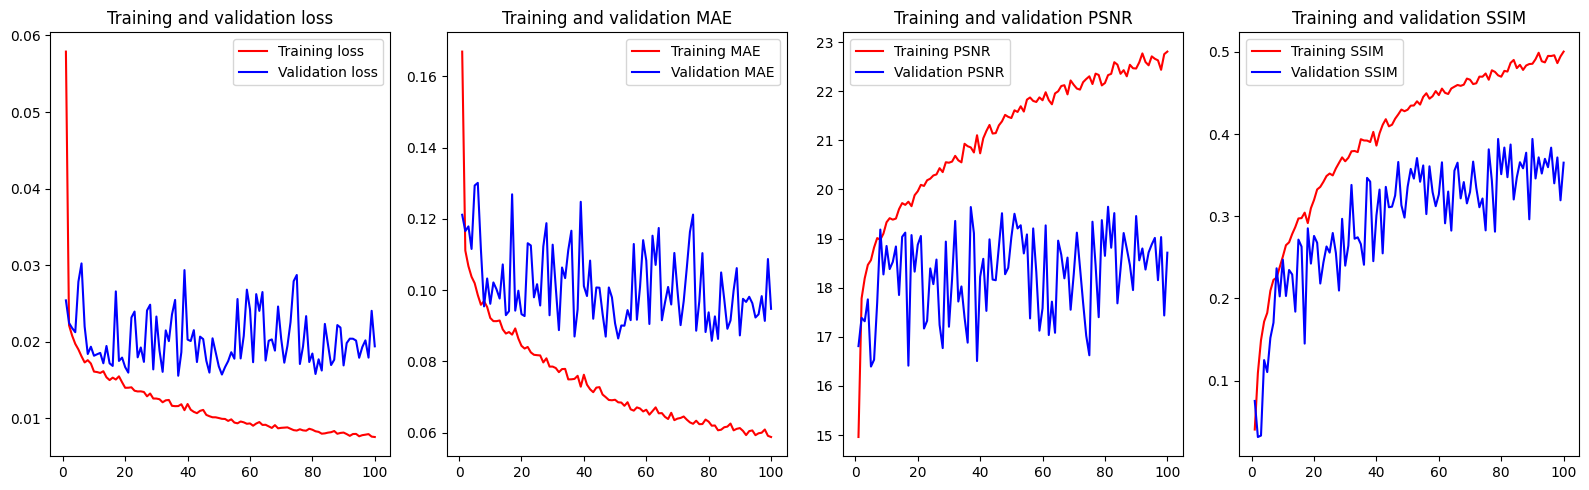

Time taken for denoising: 846.5384752750397 seconds


In [39]:
!mkdir weights

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (epochs=100, batch_size=64, l1=1e-5, l2=1e-4)

mkdir: cannot create directory ‘weights’: File exists
GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.1706 - mae: 0.3290 - psnr: 10.4531 - ssim: 0.0023
Epoch 1: val_loss improved from inf to 0.96718, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - loss: 1.1667 - mae: 0.3250 - psnr: 10.5698 - ssim: 0.0025 - val_loss: 0.9672 - val_mae: 0.1444 - val_psnr: 15.7079 - val_ssim: 0.0183
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.9367 - mae: 0.1182 - psnr: 17.1843 - ssim: 0.0634
Epoch 2: val_loss improved from 0.96718 to 0.88181, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - loss: 0.9361 - mae: 0.1181 - psnr: 17.1937 - ssim: 0.0638 - val_loss: 0.8818 - val_mae: 0.1221 - val_psnr: 17.0740 - val_ssim: 0.0417
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.8607 - mae: 0.1104 - psnr: 17.8728 - ssim: 0.1059
Epoch 3: val_loss

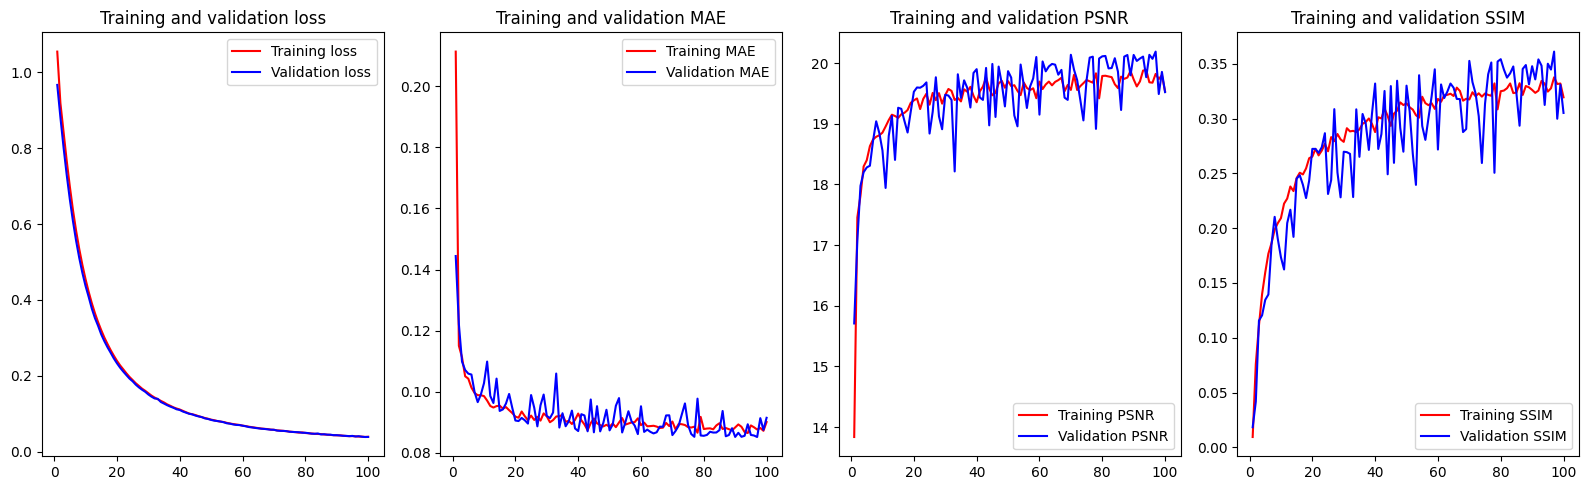

Time taken for denoising: 857.1448826789856 seconds


In [44]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=64, l1=1e-4, l2=1e-3)

GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 9.3473 - mae: 0.3399 - psnr: 10.0448 - ssim: 0.0178
Epoch 1: val_loss improved from inf to 7.00620, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - loss: 9.3215 - mae: 0.3355 - psnr: 10.1611 - ssim: 0.0180 - val_loss: 7.0062 - val_mae: 0.1255 - val_psnr: 16.6343 - val_ssim: 0.0134
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 6.3724 - mae: 0.1208 - psnr: 16.9531 - ssim: 0.0494
Epoch 2: val_loss improved from 7.00620 to 4.63660, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - loss: 6.3530 - mae: 0.1207 - psnr: 16.9608 - ssim: 0.0500 - val_loss: 4.6366 - val_mae: 0.1122 - val_psnr: 17.6852 - val_ssim: 0.0894
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 4.2287 - mae: 0.1119 - psnr: 17.7427 - ssim: 0.0951
Epoch 3: val_loss improved from 4.63660 to 3.15401, saving model to ./w

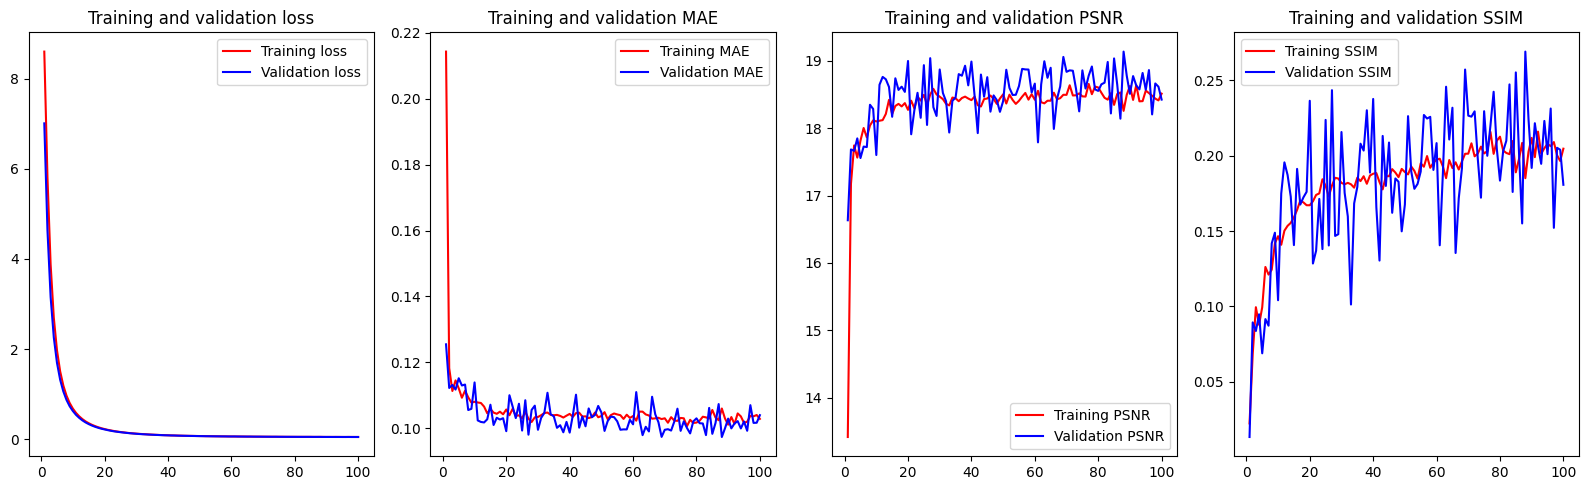

Time taken for denoising: 852.5365478992462 seconds


In [46]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=32, l1=1e-3, l2=1e-2)

GPUs available: 2
Number of devices: 2
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 72.9297 - mae: 0.2639 - psnr: 13.0335 - ssim: 0.0038
Epoch 1: val_loss improved from inf to 21.67728, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 72.5707 - mae: 0.2621 - psnr: 13.0805 - ssim: 0.0038 - val_loss: 21.6773 - val_mae: 0.1216 - val_psnr: 17.1471 - val_ssim: -0.0117
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 15.9871 - mae: 0.1210 - psnr: 17.2028 - ssim: -0.0123
Epoch 2: val_loss improved from 21.67728 to 6.15619, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 15.9156 - mae: 0.1210 - psnr: 17.2025 - ssim: -0.0123 - val_loss: 6.1562 - val_mae: 0.1219 - val_psnr: 17.1853 - val_ssim: -0.0301
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.0421 - mae: 0.1225 - psnr: 17.1717 - ssim: -0.0219
Epoch 3: val_loss improved from 6.15619 to 2.77979, saving 

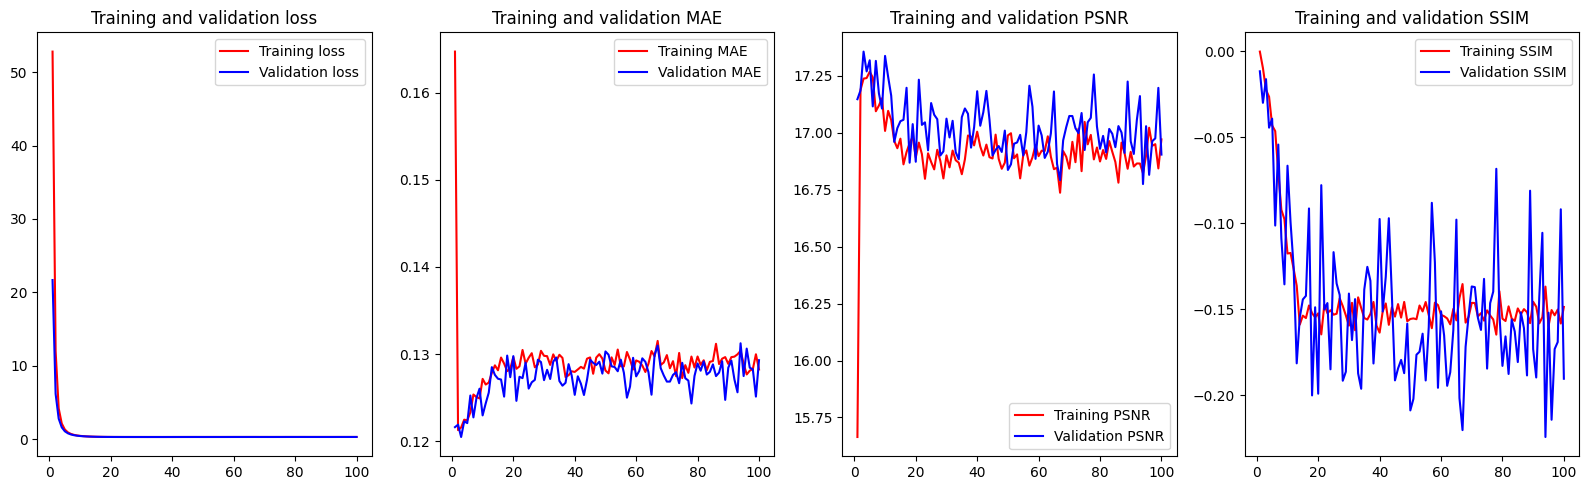

Time taken for denoising: 854.705798625946 seconds


In [48]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=32)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=64, l1=1e-6, l2=1e-5)

GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2145 - mae: 0.2280 - psnr: 13.3223 - ssim: 0.0277
Epoch 1: val_loss improved from inf to 0.12366, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.2124 - mae: 0.2257 - psnr: 13.4007 - ssim: 0.0280 - val_loss: 0.1237 - val_mae: 0.1269 - val_psnr: 16.5452 - val_ssim: 0.0425
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1201 - mae: 0.1165 - psnr: 17.4329 - ssim: 0.0748
Epoch 2: val_loss did not improve from 0.12366
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - loss: 0.1201 - mae: 0.1165 - psnr: 17.4371 - ssim: 0.0753 - val_loss: 0.1254 - val_mae: 0.1473 - val_psnr: 15.4298 - val_ssim: -0.0330
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.1154 - mae: 0.1078 - psnr: 18.1565 - ssim: 0.1354
Epoch 3: val_loss improved from 0.12366 to 0.12038, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━

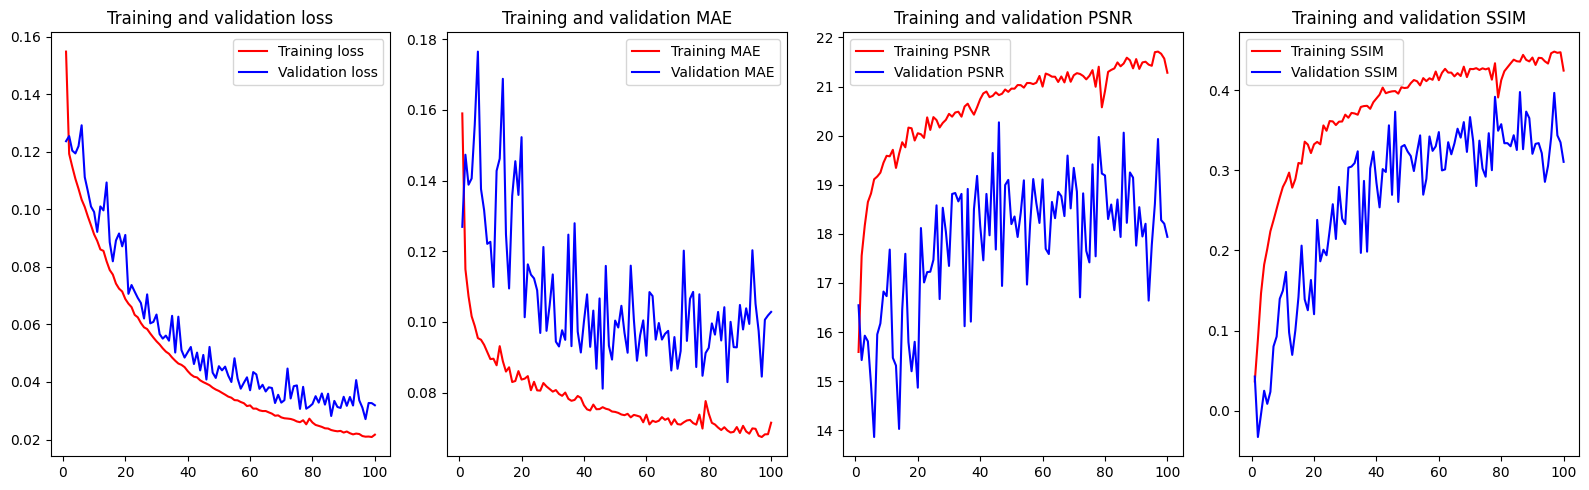

Time taken for denoising: 837.7568469047546 seconds


In [51]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=256, l1=1e-6, l2=1e-5)

GPUs available: 2
Number of devices: 2
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4184 - mae: 0.4477 - psnr: 6.9583 - ssim: 0.0116
Epoch 1: val_loss improved from inf to 0.13725, saving model to ./weights/model_unet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 0.4083 - mae: 0.4382 - psnr: 7.1781 - ssim: 0.0115 - val_loss: 0.1372 - val_mae: 0.1614 - val_psnr: 14.1865 - val_ssim: -0.0410
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - loss: 0.1375 - mae: 0.1584 - psnr: 14.5071 - ssim: -0.0091
Epoch 2: val_loss improved from 0.13725 to 0.13363, saving model to ./weights/model_unet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.1372 - mae: 0.1575 - psnr: 14.5658 - ssim: -0.0074 - val_loss: 0.1336 - val_mae: 0.1368 - val_psnr: 15.8225 - val_ssim: 0.0734
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - loss: 0.1268 - mae: 0.1291 - psnr: 16.2132 - ssim: 0.0419
Epoch 3: val_loss improved from 0.13363 to 0.12384, saving model to ./weights/model_unet_

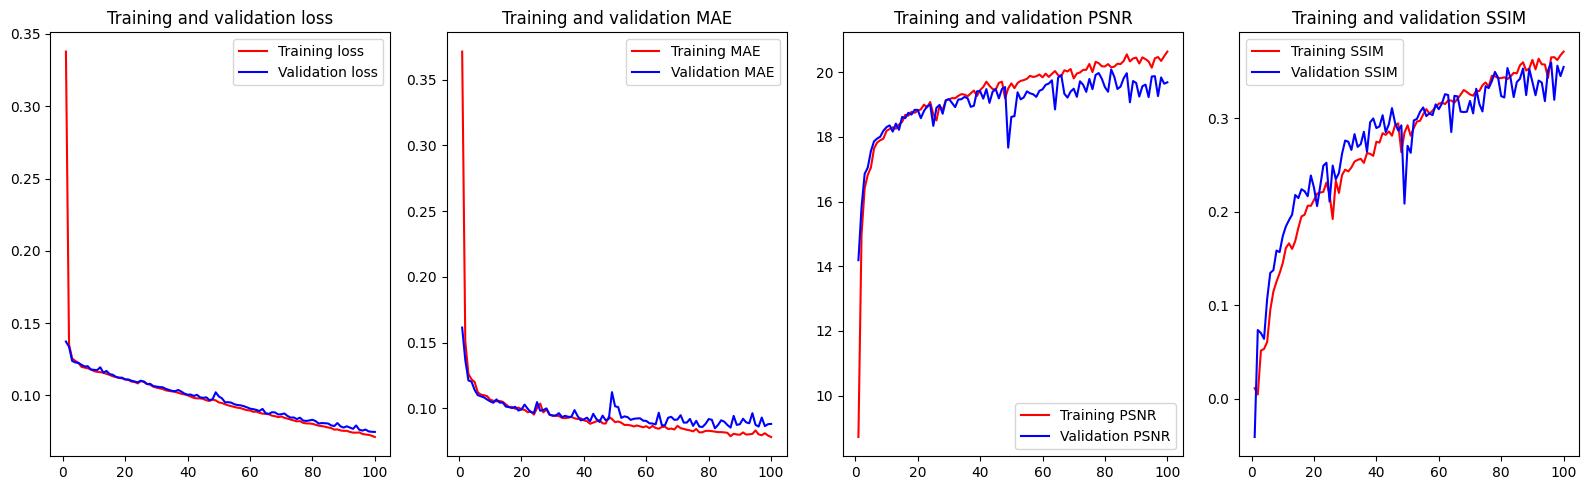

Time taken for denoising: 925.773421049118 seconds


In [52]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=256)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (8000 data, epochs=100, batch_size=64, l1=1e-5, l2=1e-4)

GPUs available: 2
Number of devices: 2
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 1.2634 - mae: 0.3894 - psnr: 10.2433 - ssim: 7.9232e-04
Epoch 1: val_loss improved from inf to 0.97079, saving model to ./weights/model_unet_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - loss: 1.2592 - mae: 0.3854 - psnr: 10.3371 - ssim: 9.3252e-04 - val_loss: 0.9708 - val_mae: 0.1479 - val_psnr: 15.0021 - val_ssim: 0.0421
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.9421 - mae: 0.1149 - psnr: 17.5668 - ssim: 0.0654
Epoch 2: val_loss improved from 0.97079 to 0.89159, saving model to ./weights/model_unet_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - loss: 0.9417 - mae: 0.1149 - psnr: 17.5718 - ssim: 0.0657 - val_loss: 0.8916 - val_mae: 0.1308 - val_psnr: 16.4677 - val_ssim: 0.0023
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.8688 - mae: 0.1076 - psnr: 18.2296 - ssim: 0.1229
Epoch 3: val_loss improved from 0.89159 to 0.82024, saving mod

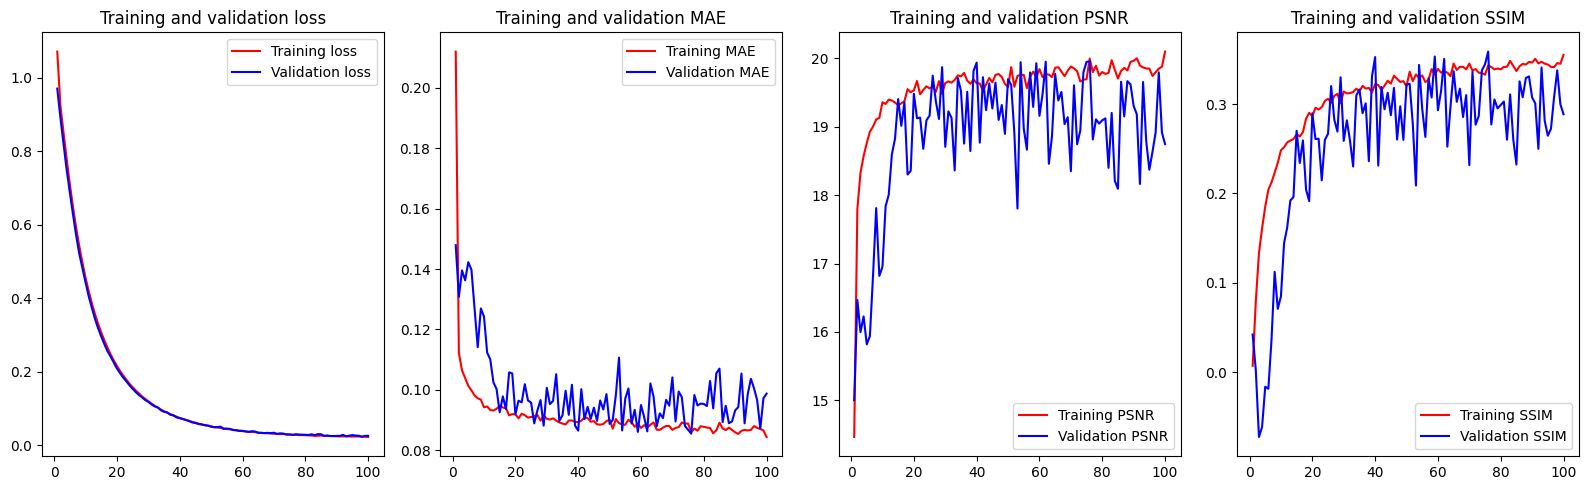

Time taken for denoising: 1342.323086977005 seconds


In [38]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# Modified structure of model:
1) Increased depth of the U-Net;
2) Residual connections;
3) use Dropout;
5) Combined Multiple Loss Functions.

In [40]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
import tensorflow as tf

# Define Perceptual Loss (VGG19-based)
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg.trainable = False  # Freeze VGG19 weights
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer("block5_conv4").output)

# Define the perceptual loss function
def perceptual_loss(y_true, y_pred):
    # Convert 1-channel to 3-channel by repeating the grayscale image
    y_true_rgb = K.repeat_elements(y_true, 3, axis=-1)
    y_pred_rgb = K.repeat_elements(y_pred, 3, axis=-1)

    # Extract features from VGG19
    y_true_features = feature_extractor(y_true_rgb)
    y_pred_features = feature_extractor(y_pred_rgb)
    
    return K.mean(K.square(y_true_features - y_pred_features))


# Define Combined Loss Function (MSE + SSIM + Perceptual + MAE)
def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    mae_loss = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    perceptual = perceptual_loss(y_true, y_pred)
    return mse_loss + 0.1 * ssim_loss + 0.1 * mae_loss + 0.2 * perceptual


def unet(input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU()
    
    # regularizer = l1_l2(l1=1e-5, l2=1e-4)  
    
    inputs = Input(input_size)
    conv_args = dict(padding='same', kernel_initializer=kernel_init, activation=activation_layer)

    # Encoder
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(inputs)
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(drop1)
    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(drop2)
    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(drop3)
    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(pool4)
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (with Residual Connections)
    up6 = Conv2D(size_filter_in*8, 2, **conv_args)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    merge6 = Conv2D(size_filter_in*8, 1, padding='same')(merge6)  # Channel projection
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(conv6)
    residual6 = Add()([conv6, merge6])


    up7 = Conv2D(size_filter_in*4, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual6))
    merge7 = concatenate([conv3, up7], axis=3)
    merge7 = Conv2D(size_filter_in*4, 1, padding='same')(merge7)  # 1x1 conv to reduce channels to 64
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(conv7)
    residual7 = Add()([conv7, merge7])  # Now both are 64 channels


    up8 = Conv2D(size_filter_in*2, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual7))
    merge8 = concatenate([conv2, up8], axis=3)
    merge8 = Conv2D(size_filter_in*2, 1, padding='same', kernel_initializer='he_normal')(merge8)  # size_filter_in*2 = 32
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(conv8)
    residual8 = Add()([conv8, merge8])  # Now both are 32 channels


    up9 = Conv2D(size_filter_in, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual8))
    merge9 = concatenate([conv1, up9], axis=3)
    merge9 = Conv2D(size_filter_in, 1, padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(conv9)
    residual9 = Add()([conv9, merge9])  # Now both have 16 channels

    conv10 = Conv2D(1, 1, activation='tanh')(residual9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss=combined_loss, metrics=['mae', 'psnr', 'ssim'])

    return model

In [ ]:
start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=100, batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

In [35]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")


    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    X_ou = X_in - X_ou

    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.30, random_state=42)

    with strategy.scope():
        generator_nn = unet()


        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras', 
            verbose=1, 
            monitor='val_loss',
            save_best_only=True, 
            mode='auto'
        )

        generator_nn.compile(
            optimizer='adam', 
            loss=combined_loss, 
            metrics=[psnr, ssim, 'mae']
        )

    history = generator_nn.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size * strategy.num_replicas_in_sync, 
        shuffle=True,
        callbacks=[checkpoint], 
        verbose=1, 
        validation_data=(X_test, y_test)
    )

    plot_training_metrics(history)

GPUs available: 2
Number of devices: 2
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 1.1736 - mae: 0.9565 - psnr: 0.2272 - ssim: 0.0185
Epoch 1: val_loss improved from inf to 0.51041, saving model to ./weights/model_unet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 1.1691 - mae: 0.9535 - psnr: 0.2509 - ssim: 0.0186 - val_loss: 0.5104 - val_mae: 0.4914 - val_psnr: 5.4589 - val_ssim: 0.0253
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - loss: 0.7070 - mae: 0.6389 - psnr: 3.4644 - ssim: 0.0076
Epoch 2: val_loss improved from 0.51041 to 0.18894, saving model to ./weights/model_unet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.6924 - mae: 0.6276 - psnr: 3.6358 - ssim: 0.0081 - val_loss: 0.1889 - val_mae: 0.1982 - val_psnr: 12.1477 - val_ssim: 0.0201
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - loss: 0.2055 - mae: 0.2202 - psnr: 11.3280 - ssim: 0.0124
Epoch 3: val_loss did not improve from 0.18894
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/

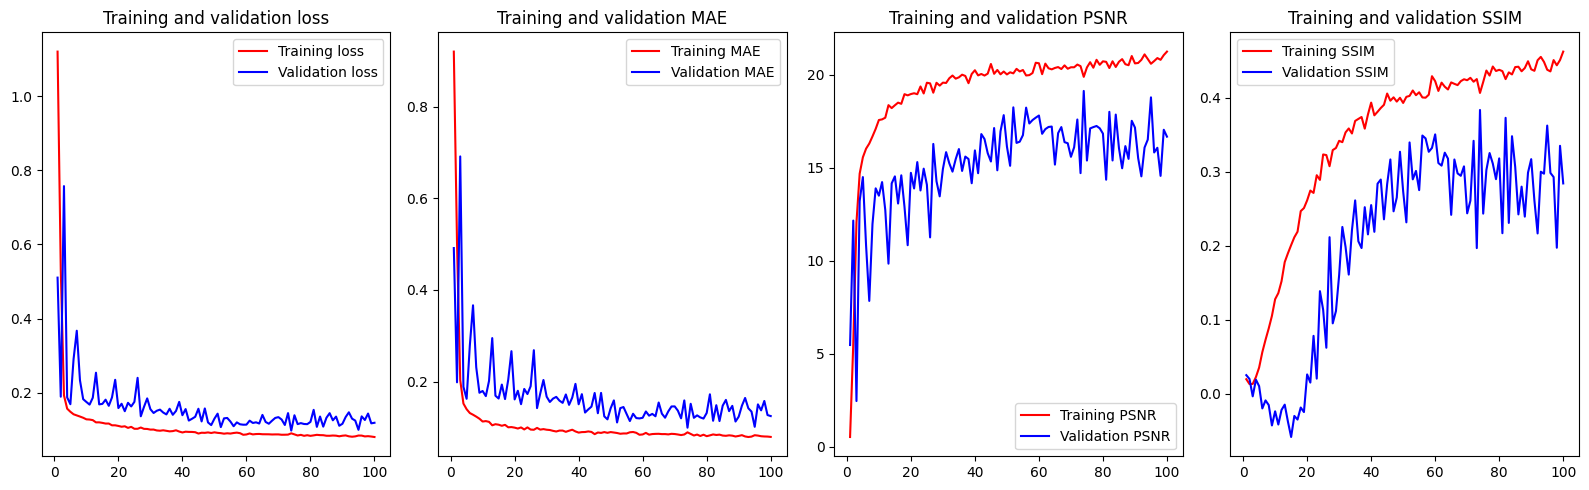

Time taken for denoising: 1109.1894037723541 seconds


In [41]:
start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=100, batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")